<b> <font size="+2.5"> Polygenic risk scores
 </b> </font> <br>

Date: 2024-01-05 <br>
Author: ASF

# Load libraries

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(readr)
library(ggplot2)
library(ggpubr)
library(car)
library(cowplot)
})

# Read in meta data and PRS

In [2]:
# read in meta_data from single nuclei RNA-seq (adata obs)
meta_data <- read.delim("../datasets/adata.obs_20231120.tsv", sep='\t')

# select meta_data of interest
meta_data <- meta_data
meta_data <- meta_data %>% select(c('individual', 'Status', 'Sex', 'Age', 'AgeBin','Brain.pH', 'RIN', 'PMI', 'X6.Batch')) %>% distinct()
meta_data <- as.data.frame(meta_data)

# format meta data
meta_data$individual <- as.character(meta_data$individual)

meta_data$RIN[is.na(meta_data$RIN)] = median(meta_data$RIN, na.rm=TRUE) 

meta_data$Status <- as.factor(as.character(meta_data$Status))
meta_data$Status <- factor(meta_data$Status, c('0','1'))
meta_data$Disease_Status <- ifelse(meta_data$Status=='0', 'Controls', 'Cases')
meta_data$Disease_Status <- factor(meta_data$Disease_Status, levels=c('Controls', 'Cases'))

meta_data$X6.Batch <- as.character(meta_data$X6.Batch)
colnames(meta_data)[which(names(meta_data) == 'X6.Batch')] <- 'lib_batch'

colnames(meta_data)[which(names(meta_data) == 'Brain.pH')] <- 'pH'

In [3]:
# read in PRS scores

file_list <-  list.files(path="../datasets/PRS", pattern=".score$", full.names=T)
names_of_files <- gsub(file_list, pattern="^.*PRS.|.plink_out.sscore$", replacement="")

# make a column with individual
PRS_scores <- list()
for (file in file_list){
    tmp <- read.delim(file, sep='\t')
    #tmp <- read_delim(file, delim = "\t", escape_double = FALSE, trim_ws = TRUE)
    tmp <- transform(tmp, individual = as.numeric(gsub("\\D", "", IID ))) # make a column with individual's number
    tmp$individual <- as.character(tmp$individual)
    PRS_scores[[file]] <- tmp}
names(PRS_scores) <- names_of_files
summary(PRS_scores)

# filter the PRS scores for individuals contained in the snRNA seq experiment N=87
PRS_scores_N87 <- list()
for (score in names(PRS_scores)){
    tmp <- PRS_scores[[score]]
    tmp <- filter(tmp, individual %in% intersect(meta_data$individual,tmp$individual))
    tmp <- merge(meta_data, tmp, by='individual')
    PRS_scores_N87[[score]] <- tmp
}

names(PRS_scores_N87) <- c('CrossDisorder', 'SCZ')

                  Length Class      Mode
crossDisorder2019 6      data.frame list
SCZ2022           6      data.frame list

In [4]:
# check if scores are normally distributed
PRS_not_normally_distributed <- c() 

for (score in names(PRS_scores_N87)){
    tmp <- PRS_scores_N87[[score]]
    ctrls <- tmp[tmp$Disease_Status=='Controls', ]
    cases <- tmp[tmp$Disease_Status=='Cases', ]
    if (shapiro.test(ctrls[,'SCORE1_AVG'])$p.value < 0.05){
        PRS_not_normally_distributed <- c(PRS_not_normally_distributed, score)
    }
    if (shapiro.test(cases[,'SCORE1_AVG'])$p.value < 0.05){
        PRS_not_normally_distributed <- c(PRS_not_normally_distributed, score)
    }
}
PRS_not_normally_distributed <- unique(PRS_not_normally_distributed)

PRS_normally_distributed <-  names(PRS_scores_N87)[!names(PRS_scores_N87) %in% PRS_not_normally_distributed]

PRS_not_normally_distributed
PRS_normally_distributed

NULL

[1] "CrossDisorder" "SCZ"

In [5]:
# check if variance is equal
norm_unequal <- c()
for (score in names(PRS_scores_N87)) {
    tmp <- PRS_scores_N87[[score]]
    res <- var.test(SCORE1_AVG ~ Disease_Status, data = tmp)
    if (res$p.value < 0.05){
        norm_unequal <- c(norm_unequal, score)
    }
}

norm_equal <- PRS_normally_distributed[!PRS_normally_distributed %in% norm_unequal]

norm_equal
norm_unequal

[1] "CrossDisorder"

[1] "SCZ"

## Extended Data Fig. 10a

In [6]:
library(plyr) 
# only load this libary here: see the package start-up message

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact




In [7]:
# define outlier function - so that outliers can then be plotted using boxplot
id_outliers <- function(x){
  q <- quantile(x,c(0.25,0.75))
  iqr <- abs(diff(q))
  ifelse((x < q[1] - 1.5*iqr) | (x > q[2] + 1.5*iqr),'Outlier','NotOutlier')
}

In [8]:
#ddply: Split data frame, apply function, and return results in a data frame
for (score in names(PRS_scores_N87)){
    PRS_scores_N87[[score]] <- as.data.frame(ddply(PRS_scores_N87[[score]],
                                  .(Disease_Status),
                                  transform,
                                  Outlier = id_outliers(SCORE1_AVG)))}

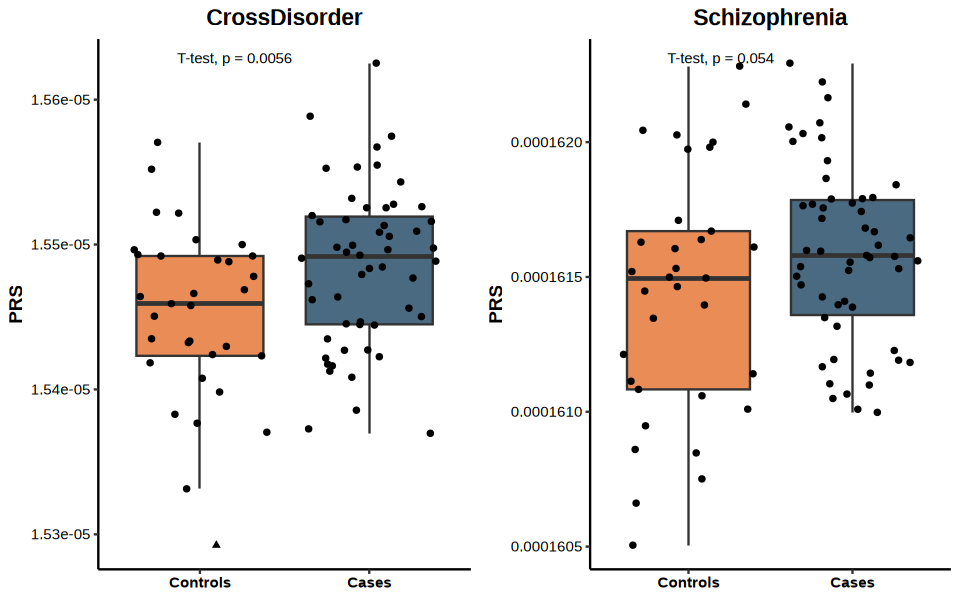

In [9]:
figList <- list()

# one-sided t-test since a higher PRS in Cases is expected
#triangles represent outliers
for (score in norm_equal){
    figList[[score]] <- ggplot(PRS_scores_N87[[score]], aes(x=Disease_Status, y=SCORE1_AVG, fill=Disease_Status)) + 
  geom_boxplot(outlier.color=NA) + geom_point(aes(colour = Disease_Status,shape = Outlier),position = "jitter", colour='black') +
theme_classic() + theme(legend.position = 'none')+ ylab('PRS') + xlab('Disease Status') + 
stat_compare_means(method = "t.test",method.args = list(var.equal = TRUE, alternative='greater'), size=3) +
theme(axis.title=element_text(face='bold'),axis.text = element_text(colour="black"), 
      axis.text.x = element_text(face="bold"), 
axis.title.x = element_blank(), plot.title = element_text(hjust = 0.5, face='bold')) + 
ggtitle(score) +scale_fill_manual(values=c("#EA8C55", "#496A81"))
  }

for (score in norm_unequal){
    figList[[score]] <- ggplot(PRS_scores_N87[[score]], aes(x=Disease_Status, y=SCORE1_AVG, fill=Disease_Status)) + 
  geom_boxplot(outlier.color=NA) + geom_point(aes(colour = Disease_Status,shape = Outlier),position = "jitter", colour='black') +
theme_classic() + theme(legend.position = 'none')+ ylab('PRS') + xlab('Disease Status') + 
stat_compare_means(method = "t.test", method.args = list(var.equal = FALSE, alternative='greater'), size=3) +
theme(axis.title=element_text(face='bold'),axis.text = element_text(colour="black"), 
      axis.text.x = element_text(face="bold"), 
axis.title.x = element_blank(), plot.title = element_text(hjust = 0.5, face='bold')) + 
ggtitle('Schizophrenia') +scale_fill_manual(values=c("#EA8C55", "#496A81"))
  }

options(repr.plot.width=8, repr.plot.height=5)
plot_grid(plotlist=figList, nrow=1)

ggsave('../figures/boxplot_PRS_CrossD&SCZ.pdf', plot=last_plot(), width=5.6, height=4)

# Supplementary Table 15

In [10]:
# polygenic risk scores

PRS <- merge(PRS_scores_N87[['CrossDisorder']][,c('individual', 'SCORE1_AVG')], PRS_scores_N87[['SCZ']][,c('individual', 'SCORE1_AVG')], by='individual')

#rename columns
colnames(PRS) <- c('individual', 'PRS_CrossD', 'PRS_SCZ')

#add anonymous donor label
library(readxl)
anonymous_donor_label <- read_excel('../datasets/anonymous_donor_label.xlsx')
PRS <- merge(anonymous_donor_label, PRS, by='individual')

#remove individual identifier
PRS$individual <- NULL

head(PRS)

,Donor,PRS_CrossD,PRS_SCZ
,<chr>,<dbl>,<dbl>
1,s1,1.54453e-05,0.000161789
2,s2,1.55057e-05,0.000161538
3,s3,1.55319e-05,0.000162056
4,s4,1.56252e-05,0.000162293
5,s5,1.54444e-05,0.000161426
6,s6,1.54334e-05,0.000161981


In [11]:
library(writexl)
#write_xlsx(PRS, '../results/cohort_descrip/PRS_CrossD_SCZ_anonymous_donor_label.xlsx', col_names = TRUE)

# SessionInfo

In [12]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] writexl_1.4.2   readxl_1.4.3    plyr_1.8.9      cowplot_1.1.1  
 [5] car_3.1-2       carData_3.0-5   ggpubr_0.6.0    lubridate_1.9.3
 [9] forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4     purrr_1.0.2    
[13]